# Titanic: Machine Learning From Disaster

## 1. Importing Libraries and Data

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [ ]:
train_df.head()

In [ ]:
test_df.head()

In [ ]:
print(f'Number of training instances: {len(train_df)}')
print(f'Number of test instances: {len(test_df)}')

In [ ]:
combined = train_df.append(test_df, sort=False).reset_index(drop=True)

In [ ]:
combined

# 2. Exploratory Data Anlaysis & Cleaning

In [ ]:
plt.figure(figsize=(12,4))
sns.countplot(y=train_df['Survived'])
plt.show()

In [ ]:
train_df['Survived'].value_counts(normalize=True)

In [ ]:
combined.isnull().mean()

We have to deal with some of these missing values (we can ignore the survived missing values because these are just from the test dataset). 20% of the Age values are missing so let's take a closer look at this data to see what the best way of approaching this is.

In [ ]:
age_not_null = combined[~np.isnan(combined['Age'])]

In [ ]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
fig.set_size_inches(12,12)
sns.boxplot(age_not_null['Age'], ax=ax_box)
sns.distplot(age_not_null['Age'], ax=ax_hist)
ax_box.set_xlabel('')
plt.show()

The Age data is slightly positively skewed, but there aren't very many outliers, so we could fill in the missing age values with either the median or the mean age.

A better way of handling these values is going to be to group the data by some characteristics, i.e. Sex, Title or Pclass, or combinations of these and take the mean. This will likely result in a more accurate approximation for the missing values.

For this analysis we are going to group by Sex and Pclass. First let's see how the mean ages between these groups differ, and whether or not this will yield a better result than just simply filling NaNs with the mean or median of the entire dataset.

In [ ]:
age_grouped = combined.copy()

In [ ]:
age_grouped = age_grouped[['Age','Sex','Pclass']].groupby(by=['Sex','Pclass']).mean().round(1)

In [ ]:
age_grouped

In the dataframe above we can see that there are quite significant differences between the groups of passengers when split up by Sex and Pclass. Let's go ahead with filling in our NaNs for the Age feature with these values.

In [ ]:
combined['Age'] = combined.groupby(by=['Sex','Pclass'], sort=False)['Age'].apply(lambda x: x.fillna(x.mean()))

In [ ]:
combined.isnull().sum()

Now we have one missing Fare value. Intuitively, Pclass will be the bes predictor of Fare, therefore we can fill in this value with the mean of the Pclass that that instance belongs to.

In [ ]:
combined['Fare'] = combined.groupby(by=['Pclass'], sort=False)['Fare'].apply(lambda x: x.fillna(x.mean()))

Next we have the Cabin feature. 77% of these values are missing, therefore it's impossible for us to fill these NaNs with anything meaningful - we may just be adding more noise to our data and actually reducing our performance. Therefore we'll drop this feature entirely.

In [ ]:
combined.drop(columns='Cabin', inplace=True)

Finally, there are two missing Embarked values. It's not obvious which features will be the best predictor of where the customer embarked the ship, so let's visualise this feature against some of the others to find out how we can handle these.

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.countplot('Embarked', data=combined, hue='Pclass')
plt.subplot(1,2,2)
sns.countplot('Embarked', data=combined, hue='Sex')
plt.show()

It's clear here that both Pclass and Sex can both help us with filling in these NaN values. If you're a in Pclass 3 and a man then you are more likely to be boarding at S! Since Embarked is a categorical variable, we can't just groupby and fill the NaN with the mean. The easiest was to do this is manually.

In [ ]:
combined.loc[combined['Embarked'].isnull()]

Both of these passengers are female and in Pclass 1, so they are most likely to have boarded at S.

In [ ]:
combined['Embarked'] = combined['Embarked'].fillna('S')

In [ ]:
combined.isnull().sum()

That's it, there are no NaN values left so we can move onto the next stage of the preprocessing.

The name column doesn't currently enrigh our dataset in any way at the moment, however if we extract the title out of the name then that will give us more information about the individual such as social and marital status.

In [ ]:
combined['Title'] = combined['Name'].str.split().apply(lambda x: x[1])

In [ ]:
combined

In [ ]:
combined['Title'].value_counts(normalize=False)

Everything after Master we will group into another category named 'Other'as there is very little representation from each of those groups so any models we use will unlikely be able to draw any statistically significant meaning from them.

In [ ]:
combined['Title'] = combined['Title'].apply(lambda x: 'Other' if x not in ['Mr.','Miss.','Mrs.','Master.'] else x)

In [ ]:
combined['Title'].value_counts(normalize=False)

As mentioned before, the Name feature isn't adding any more value to the dataset. Neither is Ticket in it's current form. The ticket number is not unique, groups travelling together share the same ticket, so coutning the number of people in that group could add some value, however any effect from this is also going to be somewhat capturesd by SibSp and Parch. Lastly, the PassengeId column is simply an index so we can also remove it from the dataset.

In [ ]:
len(combined['Ticket'].unique())

In [ ]:
combined.drop(columns=['Name','Ticket','PassengerId'], inplace=True)

## 3. Normalising and Encoding the Data

In [ ]:
e_combined = combined.copy()

In [ ]:
cat_features = ['Pclass','Sex','Embarked','Title']

In [ ]:
combined

In [ ]:
e_combined = pd.get_dummies(e_combined, columns=cat_features)

In [ ]:
s_combined = combined.copy()

In [ ]:
num_features = ['Age','SibSp','Parch','Fare']

In [ ]:
scalar = StandardScaler()

In [ ]:
ct = ColumnTransformer(
    [('num', scalar, num_features)], remainder='passthrough'
    )

In [ ]:
s_combined = pd.DataFrame(ct.fit_transform(s_combined))

In [ ]:
s_combined

In [ ]:
s_combined.columns = num_features + ['Survived'] + cat_features

In [ ]:
s_combined

In [ ]:
e_s_combined = s_combined.copy()

In [ ]:
e_s_combined = pd.get_dummies(e_s_combined, columns=cat_features)

Saving data to csv files.

In [ ]:
train_df = combined.loc[:890]

In [ ]:
test_df = combined.loc[891:].reset_index(drop=True)

In [ ]:
train_df.to_csv('data/train_cleaned.csv')

In [ ]:
test_df.to_csv('data/test_cleaned.csv')

In [ ]:
e_train_df = e_combined.loc[:890]

In [ ]:
e_test_df = e_combined.loc[891:].reset_index(drop=True)

In [ ]:
e_train_df.to_csv('data/e_train_cleaned.csv')

In [ ]:
e_test_df.to_csv('data/e_test_cleaned.csv')

In [ ]:
s_train_df = s_combined.loc[:890]

In [ ]:
s_test_df = s_combined.loc[891:].reset_index(drop=True)

In [ ]:
s_train_df.to_csv('data/s_train_cleaned.csv')

In [ ]:
s_test_df.to_csv('data/s_test_cleaned.csv')

In [ ]:
e_s_train_df = e_s_combined.loc[:890]

In [ ]:
e_s_test_df = e_s_combined.loc[891:].reset_index(drop=True)

In [ ]:
e_s_train_df.to_csv('data/e_s_train_cleaned.csv')

In [ ]:
e_s_test_df.to_csv('data/e_s_test_cleaned.csv')

## 4. Modelling

In [72]:
def make_roc_curves(model, X_train, X_val):
    train_prob = model.predict_proba(X_train)[:,1]
    val_prob = model.predict_proba(X_val)[:,1]
    plt.figure(figsize=(10,10))
    for data in [[y_train, train_prob],[y_val, val_prob]]:
        fpr, tpr, thresh = roc_curve(data[0], data[1])
        plt.plot(fpr, tpr)
    k = 0
    for i, j in zip(fpr, tpr):
        if k % 2 == 0:
            plt.annotate(str(round(thresh[k],2)),xy=(i,j), textcoords='data')
        k += 1
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.ylabel('TPR (power)')
    plt.xlabel('FPR (alpha)')
    plt.legend(['train','val'])
    plt.show()

In [2]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### 4.1. Logistic Regression

In [3]:
dtypes = {
    'Survived': 'int64',
    'Pclass': 'category',
    'Sex': 'category',
    'Age': 'float64',
    'SibSp': 'int',
    'Parch': 'int',
    'Fare': 'float',
    'Embarked': 'category',
    'Title': 'category'
}

In [4]:
train_df = pd.read_csv('data/e_s_train_cleaned.csv').drop(columns='Unnamed: 0')

In [7]:
y = train_df['Survived']

In [8]:
X = train_df.drop(columns='Survived')

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.15)

In [17]:
params = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1','l2'], 'solver': ['liblinear','saga']}

In [18]:
clf = GridSearchCV(LogisticRegression(),
                   params,
                   cv=kfold,
                   verbose=1,
                   refit=True,
                   scoring='roc_auc')

In [36]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.7s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=1)

In [39]:
clf.score(X_val, y_val)

0.9017857142857143

In [40]:
model = clf.best_estimator_

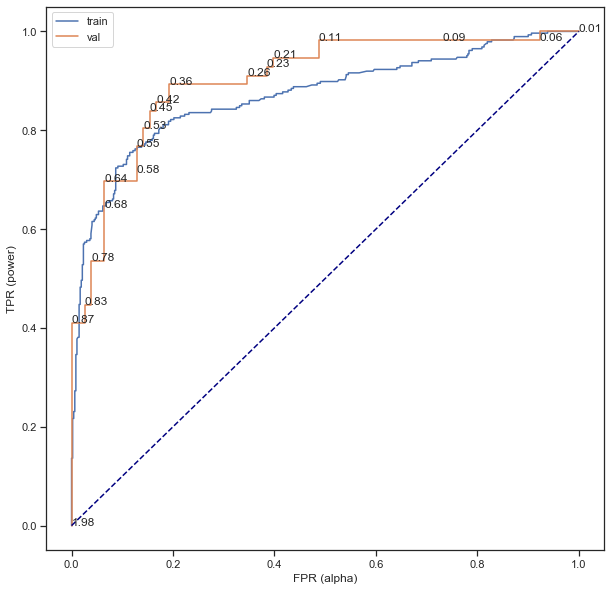

In [73]:
make_roc_curves(model, X_train, X_val)

### 4.2. Naive Bayes

In [79]:
nb_clf = GaussianNB()

In [80]:
nb_clf.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [82]:
nb_clf.score(X_val, y_val)

0.8134328358208955

### 4.3. K Nearest Neighbours

In [90]:
knn_clf = KNeighborsClassifier()

In [95]:
params = {'n_neighbors':[2,3,4,5,6,7,8,9,10], 'weights': ['uniform', 'distance'], 'p': [1, 2]}

In [96]:
clf = GridSearchCV(knn_clf,
                   params,
                   cv=kfold,
                   verbose=1,
                   refit=True,
                   scoring='roc_auc',
                   n_jobs=-1)

In [97]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 149 out of 180 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    0.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=1)

In [100]:
model = clf.best_estimator_

In [113]:
clf.score(X_val, y_val)

0.8788919413919415

In [102]:
make_roc_curves(model, X_train, y_train)

ValueError: Expected 2D array, got 1D array instead:
array=[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1.
 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1.
 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1.
 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1.
 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0.
 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1.
 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1.
 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1.
 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0.
 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0.
 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1.
 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1.
 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### 4.4. Support Vector Machine

In [105]:
svm = SVC()

In [106]:
params = {'C': [0.001, 0.01, 0.1, 1 ,10], 'degree': [1,2,3,4,5], 'kernel': ['linear', 'poly', 'rbf']}

In [107]:
clf = GridSearchCV(svm,
                   params,
                   cv=kfold,
                   verbose=1,
                   refit=True,
                   scoring='roc_auc',
                   n_jobs=-1)

In [108]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 287 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:    3.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'degree': [1, 2, 3, 4, 5],
                         'kernel': ['linear', 'poly', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=1)

In [111]:
clf.score(X_val, y_val)

0.8788919413919415

### 4.5. Decision Tree

### 4.6. Random Forest

### 4.7. Neural Network